# Linear Vortex Panel Method

The following notebook is about implementation of  a linear intensity panel method where a linearly varying intensity vortex
sheet is placed on each panel. We have used cylinder as our test case to verify our resutls. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy
import cmath

In [2]:
class Panel:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.xc = (x1 + x2) * 0.5
        self.yc = (y1 + y2) * 0.5
        self.zc = self.xc + 1j*(self.yc)
        self.z1 = self.x1 + 1j*(self.y1)
        self.z2 = self.x2 + 1j*(self.y2)
        self.length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if (x2 - x1)<0:
            self.angle = math.acos((y2-y1)/self.length)
        else:
            self.angle = math.pi + math.acos(-(y2-y1)/self.length)
        self.gamma = 0.0

We have created a class by name Panel which contains all the necessary information regarding the panel. Lets look at the how these panels are created along the cylinder.

In [3]:
def create_panels(N=20, R=1.0):
    theta = (np.linspace(0, 2*np.pi, N+1))
    x = R * np.cos(theta)
    y = R * np.sin(theta)
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels


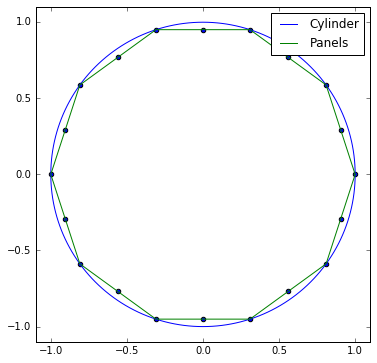

In [4]:
R = 1.0
panels = create_panels(N=10, R=1.0)
x = R*np.cos(np.linspace(0, 2*np.pi,11))
y = R*np.sin(np.linspace(0, 2*np.pi,11))
theta = np.linspace(0,2*np.pi,200+1)
x_cylinder = R*np.cos(theta)
y_cylinder = R*np.sin(theta)
plt.figure(figsize=(6,6))
plt.plot(x_cylinder, y_cylinder,label='Cylinder')
plt.plot(x, y, label='Panels')
plt.scatter([p.x1 for p in panels], [p.y1 for p in panels])
plt.scatter([p.xc for p in panels], [p.yc for p in panels])
plt.legend()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()

Lets define some functions which help to compute the matrices A, B.
We intend to solve 
    A $\Gamma$ = B

In [33]:
def compute_A(N=20, R=1.0):
    panels = create_panels(N=N, R=R)
    A = np.empty((N+1, N+1), dtype=float)
    np.fill_diagonal(A,0.0)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            theta = cmath.phase(p_j.z2 - p_j.z1)
            theta1 = cmath.phase(panels[j-1].z2 - panels[j-1].z1)
            zr = (p_i.zc - p_j.z1)*np.exp(-1j*theta)
            zl = (p_i.zc - panels[j-1].z1)*np.exp(-1j*theta1)
            l = abs(p_i.z1 - p_i.z2)
            vel_l = np.conj((1j/(2.*np.pi))*(np.log((zl - l)/zl)*(zl/l) + 1.))*np.exp(1j*theta1)
            vel_r = np.conj((-1j/(2.*np.pi))*(np.log((zr - l)/zr)*(zr/l - 1.) + 1.))*np.exp(1j*theta)
            A[i][j] = ((vel_l + vel_r)*(np.exp(-1j*(p_i.angle - np.pi)))).real
            A[N,i] = p_i.length
            A[i,N] = 0.0
    return A


In [35]:
def compute_B(N=20, R=1.0, u_inf=1.0, u_body=0.0):
    panels = create_panels(N, R)
    B = u_inf * np.cos([p.angle for p in panels])
    B = np.append(B,0)
    return B

In [36]:
def solver(N=20, R=1.0, u_inf=1.0, u_body=0.0):
    panels = create_panels(N, R)
    A = compute_A(N, R)
    B = compute_B(N, R, u_inf, u_body)
    gamma = np.linalg.lstsq(A,B)[0]
    for i, p in enumerate(panels):
        p.gamma = gamma[i]
    return panels

We have implemented two methods to compute matrix A which has the influence coefficients by rotation of the panel given by compute_A() function
 

In [135]:
def vortex_velocity(panels, p_i, j, z):
	gamma = panels[j].gamma
	theta = np.angle(panels[j].z2 - panels[j].z1)
	theta1 = cmath.phase(panels[j-1].z2 - panels[j-1].z1)
	zr = (z - panels[j].z1)*np.exp(-1j*theta)
	zl = (z - panels[j-1].z1)*np.exp(-1j*theta1)
	l = abs(p_i.z1 - p_i.z2)
	vel_l = np.conj((1j/(2.*np.pi))*(np.log((zl - l)/zl)*(zl/l) + 1.))*np.exp(1j*theta1)
	vel_r = np.conj((-1j/(2.*np.pi))*(np.log((zr - l)/zr)*(zr/l - 1.) + 1.))*np.exp(1j*theta)
	return (vel_l + vel_r) * gamma

def compute_velocity(panels,z,N=20, R=1.0, u_inf=0.0):
    vel = 0.0
    for i, p_i in enumerate(panels):
        vel = vel + vortex_velocity(panels, p_i,i, z)
    vel = vel + u_inf
    return (vel)

def actual_velocity(u_inf=1.0,radius=1.5, no_of_points=200, R=1.):
	theta = np.linspace(-np.pi, np.pi, no_of_points+1)
	v_theta = -(1 + (R/radius)**2)*u_inf*np.sin(theta)
	v_r = (1 - (R/radius)**2)*u_inf*np.cos(theta)
	vel =  (-v_theta*np.sin(theta) + v_r*np.cos(theta)) + 1j * (v_r*np.sin(theta) + v_theta*np.cos(theta))
	return vel

def numerical_velocity(panels,N, radius=1.5, no_of_points=200, R=1.,u_inf=1.0):
	theta = np.linspace(-np.pi, np.pi, no_of_points+1)
	x_array = radius * np.cos(theta)
	y_array = radius * np.sin(theta)
	z_array = x_array + 1j*y_array
	vel = []
	for i in range(len(z_array)):
		vel.append(compute_velocity(panels,z_array[i], N, R,u_inf))
	return np.asarray(vel)

The above block functions are used to compute velocities at a given location.
The function numerical_velocity gives the velocity due to panels while the function actual_velocity gives the theroretical velocity for flow past a cylinder

# 1. Error vs Number of panels

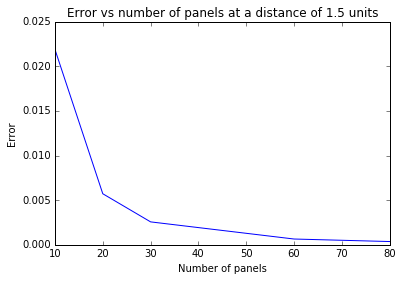

In [121]:
n_panels = [10,20,30,60,80]
def error_compute():
    n_panels = [10,20,30,60,80]
    Error = []
    no_of_points = 200
    for n in n_panels:
        panels = solver(N=n, R=1.0, u_inf=1.0, u_body=0.0)
        v_actual = actual_velocity(radius=1.5, no_of_points=200, R=1.)
        v_numerical = numerical_velocity(panels, N=n,radius=1.5, no_of_points=200, R=1.,u_inf=1.0)
        Error.append(sum(abs(abs(v_actual) - abs(v_numerical)))/no_of_points)
        #Error.append(abs(sum(v_actual - v_numerical))/no_of_points)
    return Error

Error = error_compute()
plt.plot(n_panels, Error)
plt.xlabel('Number of panels')
plt.ylabel('Error')
plt.title('Error vs number of panels at a distance of 1.5 units')
plt.show()

# 2. Error vs Radial distance

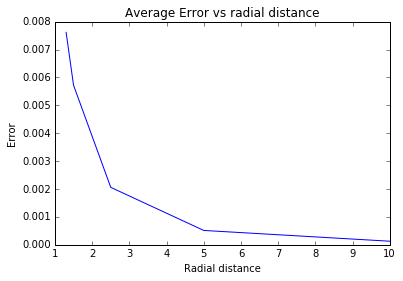

In [122]:
def error_radial(N=20):
    radius_array =[1.3, 1.5, 2.5, 5.0, 10.]
    Error = []
    no_of_points = 200
    for r in radius_array:
        panels = solver(N=N, R=1.0, u_inf=1.0, u_body=0.0)
        v_actual = actual_velocity(radius=r, no_of_points=200, R=1.)
        v_numerical = numerical_velocity(panels, N=N,radius=r, no_of_points=200, R=1.,u_inf=1.0)
        Error.append(sum(abs(abs(v_actual) - abs(v_numerical)))/no_of_points)
        #Error.append(abs(sum(v_actual - v_numerical))/no_of_points)
    return Error

radius_array = [1.3, 1.5, 2.5, 5.0, 10.]
Error = error_radial()
plt.plot(radius_array, Error)
plt.xlabel('Radial distance')
plt.ylabel('Error')
plt.title('Average Error vs radial distance')
plt.show()

# 3. Motion of a point vortex placed near a cylinder

## Method of Images

Now, lets look at the motion of a point vortex placed outside the cylinder using the concept of Method of images.

The point vortex is placed at say (1.5,0) and the cylinder is placed with centre (0,0). The image of the vortex of strength -$\gamma$ is placed inside the cylinder. Another vortex of same strength $\gamma$ is placed at the centre of the cylinder.

In [87]:
R = 1.0
pos = 1.5 + 1j*0

In [88]:
image = R*R/(pos.conjugate())
theta = np.linspace(0,2*np.pi,200+1)
x_cylinder = R*np.cos(theta)
y_cylinder = R*np.sin(theta)

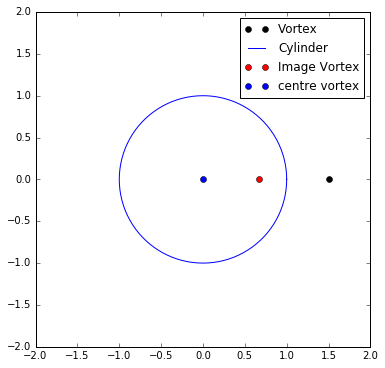

In [89]:
plt.figure(figsize=(6, 6))
plt.axis([-2.,2.,-2.,2.])
plt.plot(pos.real,pos.imag,'ko',label='Vortex')
plt.plot(x_cylinder,y_cylinder,label='Cylinder')
plt.plot(image.real,image.imag,'ro',label='Image Vortex')
plt.plot(0,0,'bo',label='centre vortex')
plt.legend()
plt.show()

Now lets integrate the velocity of the particle using Runge-Kutta(2 order) to get the trajectory of the vortex.

In [136]:
def vortex_velocity1(z, vor, gamma):
	compl_vel = -1j*gamma/(2*np.pi*(z - vor))
	return compl_vel.conjugate()

def trajectory_image(R,pos,gamma,dt,tf):
    vor_pos = [pos]
    vori_pos = []
    t = 0.
    while t<tf:
        imag1 = R*R/(pos.conjugate())
        vori_pos.append(copy.copy(imag1))
        imag2 = 0 + 0j
        v = vortex_velocity1(pos,imag1,-gamma) + vortex_velocity1(pos,imag2,gamma)
        midpos = pos + v*dt/2.
        imag1 = R*R/(midpos.conjugate())
        v = vortex_velocity1(midpos,imag1,-gamma) + vortex_velocity1(midpos,imag2,gamma)
        pos = pos + v*dt
        vor_pos.append(copy.copy(pos))
        t = t+dt
    vor_post = np.asarray(vor_pos)
    vori_post = np.asarray(vori_pos)
    return vor_post, vori_post
    

In [91]:
vor_post, vori_post = trajectory_image(R=1.0, pos=1.5+1j*0, gamma=2*np.pi, dt=0.1, tf=20)

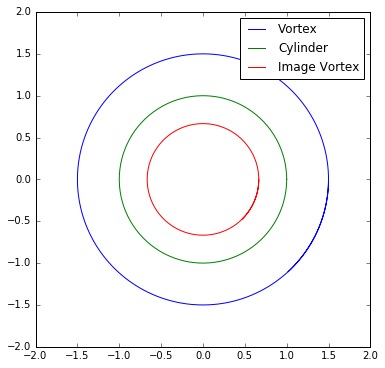

In [92]:
theta = np.linspace(0,2*np.pi,200)
x_cylinder = R*np.cos(theta)
y_cylinder = R*np.sin(theta)
plt.figure(figsize=(6, 6))
plt.axis([-2.,2.,-2.,2.])
plt.plot(vor_post.real,vor_post.imag,label='Vortex')
plt.plot(x_cylinder,y_cylinder,label='Cylinder')
plt.plot(vori_post.real,vori_post.imag,label='Image Vortex')
plt.legend()
plt.show()

We can clearly see that the point vortex follows the circular path with centre as the cylinder's centre.

## Panel Method

Now here we discretize the cylinder into panels as described above. We calcuate the $\gamma$ distribution for the panels in the vicinity of the point vortex. From the computed $\gamma$ we calculate the velocity of the point vortex and move it accordingly. As the vortex moves the B matrix of the system changes and hence the $\gamma$ distribution changes accordingly. So the $\gamma$ is recomputed at every time-step.

We use same position of the vortex as used in the case for method of images.

In [93]:
z = 1.5 + 0*1j

In [154]:
def compute_B1(panels, pos, N=20, R=1.0, gamma_vortex=2*np.pi):
    B = []
    for i, p_i in enumerate(panels):
        vel =  np.conjugate(1j * gamma_vortex/(2*np.pi*(p_i.zc - pos)))
        theta = np.angle(-1j * np.conjugate(gamma_vortex/(2*np.pi*(p_i.zc - pos))))
        B.append(-abs(vel) * np.cos(theta - p_i.angle))
    B.append(0)
    return np.asarray(B)


In [161]:
def trajectory_panel(R=1.0, z=1.5+1j*0, gamma=2*np.pi, dt=0.1, tf=20, N=20):
    z_pos = []
    panels = create_panels(N=N)
    A = compute_A(N=N, R=R)
    z_pos.append(z)
    t = 0.0
    while t<tf:
        B = compute_B1(panels, z, N=N)
        gamma = np.linalg.lstsq(A,B)[0]
        for i, p in enumerate(panels):
            p.gamma = gamma[i]
        v = compute_velocity(panels, z, N=N)
        z = z + dt*v/2
        B = compute_B1(panels, z, N=N)
        gamma = np.linalg.lstsq(A,B)[0]
        for i, p in enumerate(panels):
            p.gamma = gamma[i]
        v = compute_velocity(panels, z, N=N)
        z = z+ dt*(v)	
        z_pos.append(z)
        t = t+dt
    return z_pos

In [165]:
z_pos = trajectory_panel()
z_pos = np.asarray(z_pos)

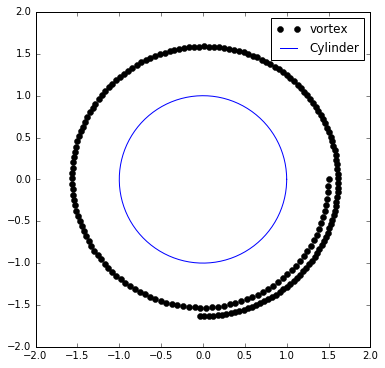

In [163]:
theta = np.linspace(0,2*np.pi,200)
x_cylinder = R*np.cos(theta)
y_cylinder = R*np.sin(theta)
plt.figure(figsize=(6, 6))
plt.axis([-2.,2.,-2.,2.])
plt.plot(z_pos.real, z_pos.imag, 'ko',label='vortex')
plt.plot(x_cylinder,y_cylinder,label='Cylinder')
plt.legend()
plt.show()

### Error between Method of images and panel method

In [166]:
def error_panel():
    no_panels = [10,20,25,35,45,55,65]
    Error = []
    for n in no_panels:
        vor_post, vori_post = trajectory_image(R=1.0, pos=1.5+1j*0, gamma=2*np.pi, dt=0.1, tf=20)
        z_pos = trajectory_panel(N=n)
        err = (-z_pos[-1] - vor_post[-1])
        Error.append(abs(err))
    return Error

Error = error_panel()

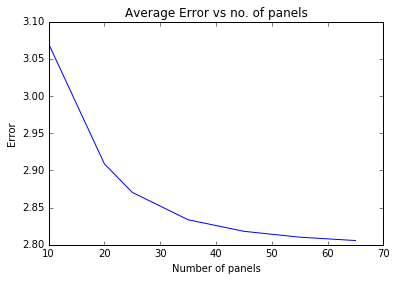

In [168]:
no_panels = [10,20,25,35,45,55,65]
plt.plot(no_panels, Error)
plt.xlabel('Number of panels')
plt.ylabel('Error')
plt.title('Average Error vs no. of panels')
plt.show()

# 4. Conclusions

1. We can see that the error decreases as the number of panel increases. This is true increase in panel number will result more finer discretization of the cylinder.

2. Similarly, the error decreases as we go away from the cylinder. Away from the cylinder, the cylinder interaction is less and it is purely freestream.

3. We clearly saw the motion of a point vortex placed outside the cylinder exhibits a circular motion about the cylinder.

4. When the same motion was studied using panel method, we saw that the vortex tried go out and also this error decreased as the number of panels were increased.